# Transformer
- Mulit-Headded Attention
    - Scaled Dot-Product Attension
- Positional Encoding
    - Vanila
    - Pytorch efficient
    - DropOut

## Multi-Headded Attention

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


### Scaled Dot-Product Attension
- Data $X \in R^{n\times d}$ whrer $n$ is the number of data and $d$ is the data dimension. Usually 512
- $Q,K\in R^{n\times d_k}$, where $d_k$ is dimension of $K$.
- $V\in R^{n\times d_v}$

##### $\text{Attention}(Q,K,V) = \text{softmax}\big(\frac{QK^T}{\sqrt{d_k}}\big)V \in \mathbb{R}^{n\times d_v}$

In [78]:
# self attention
class SDPA(nn.Module):
    def forward(self,Q,K,V,mask=None):
        d_k = K.size()[-1] # key dimension
        scores = Q.matmul(K.transpose(-2,-1))/np.sqrt(d_k)
        if mask is not None: #if mask exists
            scores = scores.maksed_fill(mask==0, -1e9) #mask == 0 인 부분에 -1e9
        attention = F.softmax(scores,dim=-1)#last dim (row vector) is a query score with other keys.
        out = attention.matmul(V)
        return out, attention
    
# Demo run
sdpa = SDPA()
n_batch,d_k,d_v = 3,128,258
Q_n, K_n, V_n = 30, 30, 30 # sequence length
Q = torch.rand(n_batch,Q_n,d_k)
K = torch.rand(n_batch,K_n,d_k)
V = torch.rand(n_batch,Q_n,d_v)
out, attention = sdpa(Q,K,V)
def sh(x): return str(x.shape)[11:-1]
print ("SDPA: Q%s K%s V%s => out%s attention%s"%
       (sh(Q),sh(K),sh(V),sh(out),sh(attention)))

#supports Multi-headedAttention as well
head = 5
Q = torch.rand(n_batch,head,Q_n,d_k)
K = torch.rand(n_batch,head,K_n,d_k)
V = torch.rand(n_batch,head,Q_n,d_v)
out, attention = sdpa(Q,K,V)
def sh(x): return str(x.shape)[11:-1]
print ("SDPA: Q%s K%s V%s => out%s attention%s"%
       (sh(Q),sh(K),sh(V),sh(out),sh(attention)))

#Batch 수가 head 보다 상위 dimension. 5개의 head를 3개씩 process.


SDPA: Q[3, 30, 128] K[3, 30, 128] V[3, 30, 258] => out[3, 30, 258] attention[3, 30, 30]
SDPA: Q[3, 5, 30, 128] K[3, 5, 30, 128] V[3, 5, 30, 258] => out[3, 5, 30, 258] attention[3, 5, 30, 30]


### Multi-Headed Attention (MHA)
- In the case of splitting embeddings into the number of heads and assign to each head.

In [79]:
class MHA(nn.Module):
    def __init__(self, d_feat=128,n_head=5,actv=F.relu,USE_BIAS=True,dropout_p=0.1,devise=None):
        """
        d_feat : feature dimension (same for each input words)
        n_head : number of heads
        actv : activation function after each linear
        USE_BIAS : whether to use bias
        dropout_p : dropout rate
        device : device select
        """

        super(MHA,self).__init__()
        if (d_feat%n_head) != 0:
            raise ValueError(f"d_feat({d_feat}) should be divisible by ({n_head})")
        self.d_feat = d_feat
        self.n_head = n_head
        self.d_head = self.d_feat // self.n_head
        self.actv = actv
        self.USE_BIAS = USE_BIAS
        self.dropout_p = dropout_p
        
        # embedding 된 latent vector 상태로 들어옴
        self.lin_Q = nn.Linear(d_feat,d_feat,self.USE_BIAS)
        self.lin_K = nn.Linear(d_feat,d_feat,self.USE_BIAS)
        self.lin_V = nn.Linear(d_feat,d_feat,self.USE_BIAS)
        self.lin_O = nn.Linear(d_feat,d_feat,self.USE_BIAS)
        #dropout arg 는 %로 주고, 클래스 안에서 nn.dropout 함수에 전달.
        self.dropout = nn.Dropout(p=self.dropout_p)

    def forward(self,Q,K,V,mask=None):
        """
        Q:[n_batch,n_Q,d_feat]
        K:[n_batch,n_K,d_feat]
        V:[n_batch,n_V,d_feat], where n_K == n_V
        """

        n_batch = Q.shape[0] # Q는 batch 단위로 들어온다
        Q_feat = self.lin_Q(Q) # [n_batch, n_Q, d_feat]
        K_feat = self.lin_K(K) 
        V_feat = self.lin_V(V)
        
        #It is important to shape the lower dimension first and then permutate.
        #Actually I don't gettit.
        Q_split = Q_feat.view(n_batch,-1,self.n_head,self.d_head).permute(0,2,1,3)
        K_split = K_feat.view(n_batch,-1,self.n_head,self.d_head).permute(0,2,1,3)
        V_split = V_feat.view(n_batch,-1,self.n_head,self.d_head).permute(0,2,1,3)
        print("K_shape:",K_split.shape)
        d_K = K_split.size()[-1] # shape이 반환하는 tuple 에서 바로 index 접근
        #K_split.size()[-1]. .size() method를 불로온 후에 index 접근
        
        scores = Q_split.matmul(K_split.transpose(-2,-1))/np.sqrt(d_K)
        if mask is not None:
            scores = scores.masked_fill(mask==0,-1e9)
        attention = torch.softmax(scores,dim=-1) #dim=-1 : softmax along dimension -1 
        print("attention shape:",attention.shape)
        # attention = [n_batch, n_head, n_Q, n_K]
        x_raw = torch.matmul(self.dropout(attention),V_split)
        # x_raw = [n_batch, n_head,n_Q,d_head]

        # Reshape x to operate add and normalization
        x_rsh1 = x_raw.permute(0,2,1,3).contiguous() #x_rh1의 객체 id 순서를 dim 1 따라 해줌
        # x_rh1 : [n_batch, n_Q, n_head, d_head]
        x_rsh2 = x_rsh1.view(n_batch,-1,self.d_feat)
        # x_rh2 : [n_batch,n_Q, d_feat]

        # Linear
        x = self.lin_O(x_rsh2)
        # x:[n_batch, n_Q, d_feat]

        out = {'Q_feat':Q_feat,'K_feat':K_feat,'V_feat':V_feat,
               'Q_split':Q_split,'K_split':K_split,'V_split':V_split,
               'scores':scores,'attention':attention,
               'x_raw':x_raw,'x_rsh1':x_rsh1,'x_rsh2':x_rsh2,'x':x} # x is the output of MHA
        return out


In [91]:
# Self-Attention Layer
n_batch = 128
n_src   = 32
d_feat  = 200
n_head  = 5
src = torch.rand(n_batch,n_src,d_feat)
self_attention = MHA(
    d_feat=d_feat,n_head=n_head,actv=F.relu,USE_BIAS=True,dropout_p=0.1)
out = self_attention.forward(src,src,src,mask=None)


K_shape: torch.Size([128, 5, 32, 40])
attention shape: torch.Size([128, 5, 32, 32])


## Positional Embedding
$PE(pos,2i) = \sin(pos/10000^{2i/d_{model}})$

$PE(pos,2i+1) = \cos(pos/10000^{2i/d_{model}})$

- For each sequences, identical PE can be used by broadcasting within each sequence

### Vanila PE

In [81]:
import numpy as np
import math
# Basic method

def gen_pe(max_length, d_model, n):

    # empty matrix
    pe = np.zeros(max_length*d_model).reshape(max_length,d_model)

    # for each position
    for k in np.arange(max_length):

        #for each dimension
        for i in np.arange(d_model//2):
            theta = k / n**((2*i)/d_model)

            pe[k,2*i] = math.sin(theta)
            pe[k,2*i+1] = math.cos(theta)
    pe = torch.tensor(pe).unsqueeze(0)
    return pe

max_lenth = 10
n = 10
d_model = 6

positions = gen_pe(max_lenth, d_model, n)
positions[:,:5] # first dimention is for batch.

tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.4477,  0.8942,  0.2138,  0.9769],
         [ 0.9093, -0.4161,  0.8006,  0.5992,  0.4177,  0.9086],
         [ 0.1411, -0.9900,  0.9841,  0.1774,  0.6023,  0.7983],
         [-0.7568, -0.6536,  0.9594, -0.2820,  0.7590,  0.6511]]],
       dtype=torch.float64)

### Pytorch Efficient PE

#### Since basic function consists double loop, not efficient.

divisor tranforms as following :

$\frac{1}{n^{\frac{2i}{d_{model}}}} = n^{-\frac{2i}{d_model}}=\exp^{\log(n^{-\frac{2i}{d_{model}}})}=\exp^{-\frac{2i}{d_{model}}\log(n)}=\exp^{-\frac{2i \log(n)}{d_{model}}}$

In [82]:
d_model = 4 #d_model/2 == range if i 
n = 100
div_term = torch.exp(torch.arange(0,d_model,2)*-(math.log(n)/d_model))
#torch.arange(0,d_model,2) = 0, 2, 4 , ... , 2i
div_term

tensor([1.0000, 0.1000])

In [83]:
# generating K

max_lenth = 10 #K
k = torch.arange(max_lenth).reshape(-1,1)
k

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])

In [84]:
pe = torch.zeros(max_length,d_model)
pe[:,::2] = torch.sin(k*div_term)
pe[:,1::2] = torch.cos(k*div_term)

pe = pe.unsqueeze(0) # addtional dimension for broadcasting
pe

tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0998,  0.9950],
         [ 0.9093, -0.4161,  0.1987,  0.9801],
         [ 0.1411, -0.9900,  0.2955,  0.9553],
         [-0.7568, -0.6536,  0.3894,  0.9211],
         [-0.9589,  0.2837,  0.4794,  0.8776],
         [-0.2794,  0.9602,  0.5646,  0.8253],
         [ 0.6570,  0.7539,  0.6442,  0.7648],
         [ 0.9894, -0.1455,  0.7174,  0.6967],
         [ 0.4121, -0.9111,  0.7833,  0.6216]]])

### Dropout 
-  helps with regularization and prevents neurons from co-adapting (overrelying on each other) .

In [85]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model : int, dropout : float = 0.1, max_length: int =5000):
        super(PositionalEncoding,self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_length,d_model)

        k = torch.arange(max_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0,d_model,2)*-math.log(n)/d_model)

        pe[:,0::2] = torch.sin(k*div_term)
        pe[:,1::2] = torch.cos(k*div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer("pe",pe) # save in state_dit but not a model parameter to train

    def forward(self, x):
        x = x + self.pe[:,:x.size(1)].requires_grad_(False)
        #.requires_grad(False) # x.size(1) = sequence x's length

        return self.dropout(x)

In [86]:
d_model = 4
max_length = 10
dropout = 0.0

# create the positional encoding matrix
pe = PositionalEncoding(d_model, dropout, max_length)

# preview the values
pe.state_dict()
# pe.pe

OrderedDict([('pe',
              tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
                       [ 0.8415,  0.5403,  0.0998,  0.9950],
                       [ 0.9093, -0.4161,  0.1987,  0.9801],
                       [ 0.1411, -0.9900,  0.2955,  0.9553],
                       [-0.7568, -0.6536,  0.3894,  0.9211],
                       [-0.9589,  0.2837,  0.4794,  0.8776],
                       [-0.2794,  0.9602,  0.5646,  0.8253],
                       [ 0.6570,  0.7539,  0.6442,  0.7648],
                       [ 0.9894, -0.1455,  0.7174,  0.6967],
                       [ 0.4121, -0.9111,  0.7833,  0.6216]]]))])

#### Display attension

In [106]:
def display_attention(attention, 
                      n_heads: int = 8, n_rows: int = 4, n_cols: int = 2):
  """
    Display the attention matrix for each head of a sequence.

    Args:
        sentence:     German sentence to be translated to English; list
        translation:  English sentence predicted by the model
        attention:    attention scores for the heads
        n_heads:      number of heads
        n_rows:       number of rows
        n_cols:       number of columns
  """
  # ensure the number of rows and columns are equal to the number of heads
  assert n_rows * n_cols == n_heads
    
  # figure size
  fig = plt.figure(figsize=(15,20))
    
  # visualize each head
  for i in range(n_heads):
        
    # create a plot
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    
    # select the respective head and make it a numpy array for plotting
    _attention = attention.squeeze(0)[i,:,:].cpu().detach().numpy()
    

    # plot the matrix
    cax = ax.matshow(_attention, cmap='bone')

    # set the size of the labels
    ax.tick_params(labelsize=12)

    # set the indices for the tick marks
    # ax.set_xticks(range(len(sentence)))?
    # ax.set_yticks(range(len(translation)))

    # ax.set_xticklabels(sentence)
    # ax.set_yticklabels(translation)

  plt.show()

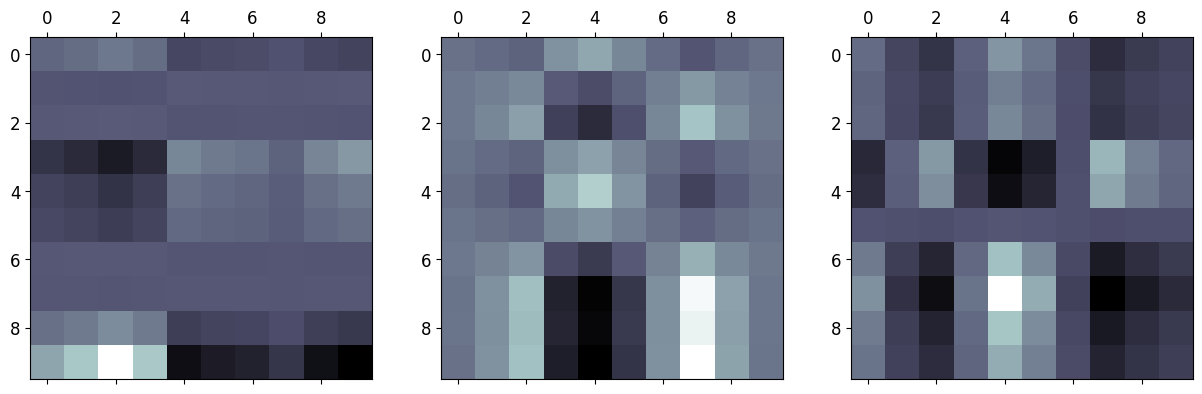

In [107]:
display_attention(out['attention'][0],n_heads=3,n_rows=1,n_cols=3)

## Feed Forward

# Whole procedure

In [94]:
d_model = 4 #dim of embeddings
max_length = 10 # sequence max length
dropout = 0.1
n = 3 # batch

# embedded data
x = torch.rand((n,max_length,d_model))

# create the positional encoding matrix
pe = PositionalEncoding(d_model, dropout, max_length)

# add pe to x
x = pe.forward(x)

# attention block
attention = MHA(d_feat = d_model, n_head = 4, actv=F.relu,USE_BIAS=True,dropout_p=0.1)
out = attention.forward(x,x,x,mask=None) # Q,K,V as x


torch.Size([3, 10, 4])
K_shape: torch.Size([3, 4, 10, 1])
attention shape: torch.Size([3, 4, 10, 10])
